<a href="https://colab.research.google.com/github/mfvc-campinho/-M.EGI026-Computer-Vision---Assignment-2/blob/main/%5BMatheus%5D%20%5BM.EGI026%5D%20Assignment%202%20ResNet-50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

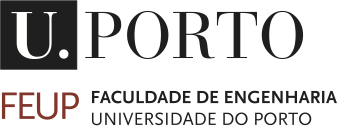   

**<h1>[M.EGI026] Computer Vision</h1>**

**<h2>Assignment #2 - XXX</h2>**

* **Filipa Mota** (up202402072@fe.up.pt)
* **Matheus Campinho** (up202402072@fe.up.pt)
<p> Department of Industrial Engineering and Management </p>  
FEUP  

----

**<h1>ResNet-50</h1>**

---
The below code cell first removes any existing content in the /content/ directory to ensure a clean slate. Then, it downloads a zip file containing the assignment data from a GitHub repository created for this purpose and extracts its contents into the /content/ directory. Finally, it prints the current directory path and lists the contents of the extracted folder.

**🛠️ Setup and Imports**

This cell imports the necessary libraries for the Computer Vision assignment:

xxx

In [1]:
# ===== Import necessary Libraries =====
import re                       # Regular expressions library
import cv2 as cv                # OpenCV library
import numpy as np              # Numpy library
import glob                     # File pattern matching library
import os                       # Operating system library
import matplotlib.pyplot as plt # Matplotlib library
import pandas as pd             # Pandas library
import random                   # Random number generation library
import math                     # Math library
import json                     # JSON library for structured data handling

In [2]:
# ===== Import necessary PyTorch modules =====
import torch                                # Main PyTorch library
import torch.nn as nn                       # Neural Network module
import torch.nn.functional as F             # Functional interface for neural networks
import torchvision                          # Computer vision library
import torchvision.transforms as transforms # Data augmentation and preprocessing
import torch.utils.data as data             # XXX
from tqdm.notebook import trange, tqdm      # XXX
from torch.optim import Adam, SGD, NAdam    # XXX
from torch.autograd import Variable         # XXX
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

**💾 Data Setup and Extraction**

This cell handles environment setup and data access in the Colab notebook:

* It **clears** the `/content/` directory.
* It **downloads** the necessary dataset ZIP file from GitHub.
* It **extracts** the files into the `/content/` directory.
* It **defines** the `path` variable for the extracted data, confirming successful setup.

In [3]:
import os
import torch

# Limpar conteudo
!rm -rf /content/*

# DOWNLOAD do ZIP correto (o dataset real)
!wget -q -O /content/infrared.zip \
  "https://github.com/RaptorMaps/InfraredSolarModules/raw/master/2020-02-14_InfraredSolarModules.zip"

# EXTRAIR
!unzip -q /content/infrared.zip -d /content/

# Verificar conteúdo
print("📁 Conteúdo em /content:", os.listdir("/content"))

# Define your execution device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # Use GPU if available, else CPU
print("The model will be running on", DEVICE, "device...") # Confirm the device being used

📁 Conteúdo em /content: ['.config', '__MACOSX', 'InfraredSolarModules', 'infrared.zip']
The model will be running on cuda:0 device...


In [4]:
from pathlib import Path
import json

data_dir = Path("/content/InfraredSolarModules")
meta_path = data_dir / "module_metadata.json"

with open(meta_path, "r") as f:
    metadata = json.load(f)

print("✔️ Metadata carregado:", len(metadata), "imagens")

✔️ Metadata carregado: 20000 imagens


**💾 CPU VS GPU**

Falta Descrição:
IMP: O GPU tem tempo máximo diário.

Para ativar:
* Vai à seccção Tempo de execução
* Clica em alterat tipo de tempo de execução
* Define Hardware Accelerator = GPU
* Reinicia o ambiente




In [5]:
!nvidia-smi
torch.cuda.is_available()

Fri Nov 28 13:36:39 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   49C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

True

# Task
Your task is to implement a complete computer vision pipeline in Google Colab to classify photovoltaic defects from thermal infrared images using a ResNet-50 model. This includes loading and exploring the "InfraredSolarModules" dataset, preprocessing and augmenting the image data, defining and setting up the ResNet-50 model for 12 defect classes, training the model for 20-40 epochs, evaluating its performance with accuracy, F1-score, and a confusion matrix, and finally discussing the results, all within a fully executable and well-documented Colab notebook.

## Dataset Loading and Exploration

### Subtask:
Load the dataset images and their corresponding labels from the JSON metadata, display the distribution of the 12 defect classes, and visualize a few sample images along with their labels.


**Reasoning**:
The first step is to extract image file paths and anomaly classes from the `metadata` dictionary and store them in a pandas DataFrame, as per the instructions.



In [6]:
data = []
for image_name, image_info in metadata.items():
    data.append({
        'image_filepath': image_info['image_filepath'],
        'anomaly_class': image_info['anomaly_class']
    })

df = pd.DataFrame(data)
print("DataFrame created successfully with", len(df), "entries.")
df.head()

DataFrame created successfully with 20000 entries.


,image_filepath,anomaly_class
0,images/13357.jpg,No-Anomaly
1,images/13356.jpg,No-Anomaly
2,images/19719.jpg,No-Anomaly
3,images/11542.jpg,No-Anomaly
4,images/11543.jpg,No-Anomaly


**Reasoning**:
Display the distribution of the 'anomaly_class' column in the DataFrame to understand the class balance, as specified in the instructions.



Distribution of anomaly classes:
anomaly_class
No-Anomaly        10000
Cell               1877
Vegetation         1639
Diode              1499
Cell-Multi         1288
Shadowing          1056
Cracking            940
Offline-Module      827
Hot-Spot            249
Hot-Spot-Multi      246
Soiling             204
Diode-Multi         175
Name: count, dtype: int64


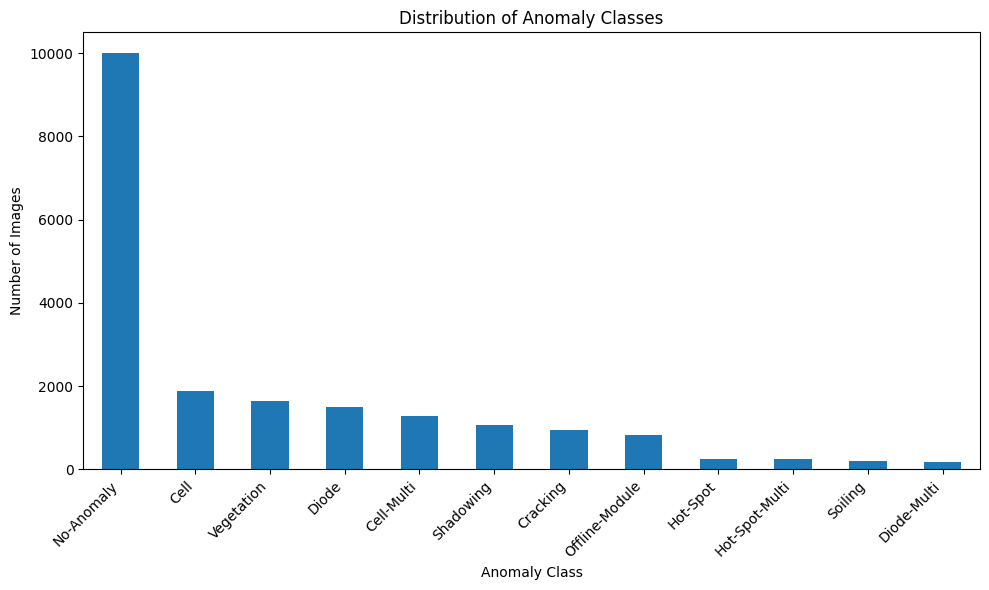

In [7]:
print("Distribution of anomaly classes:")
print(df['anomaly_class'].value_counts())

# Optional: Visualize the distribution
plt.figure(figsize=(10, 6))
df['anomaly_class'].value_counts().plot(kind='bar')
plt.title('Distribution of Anomaly Classes')
plt.xlabel('Anomaly Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Reasoning**:
Randomly select 5 unique images, load them using OpenCV, convert to RGB, and display with their anomaly class as the title, as per the instructions.



Visualizing 5 random sample images...


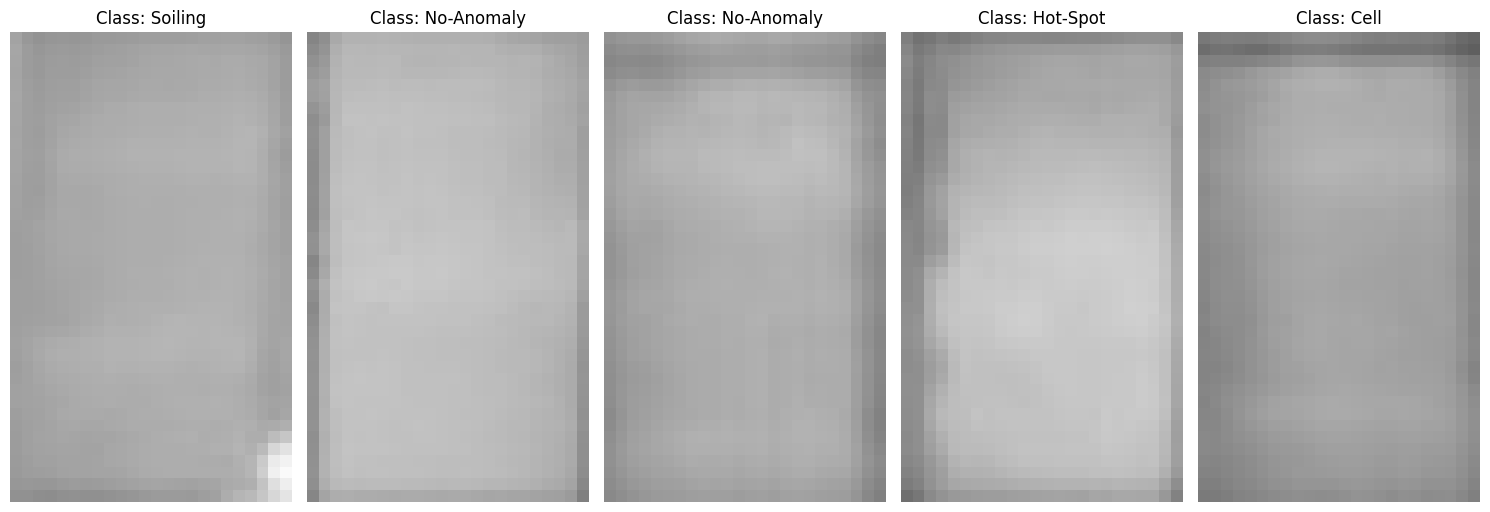

In [8]:
print("Visualizing 5 random sample images...")

# Get unique image filenames to avoid duplicates if any
unique_images = df['image_filepath'].unique()

# Randomly select 5 image file paths
sample_image_paths = np.random.choice(unique_images, size=5, replace=False)

plt.figure(figsize=(15, 10))
for i, img_filepath_relative in enumerate(sample_image_paths):
    # Construct full image path
    full_img_path = data_dir / img_filepath_relative

    # Load image using OpenCV
    img = cv.imread(str(full_img_path))

    if img is not None:
        # Convert BGR to RGB for matplotlib display
        img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)

        # Get the anomaly class for this image
        anomaly_class = df[df['image_filepath'] == img_filepath_relative]['anomaly_class'].iloc[0]

        plt.subplot(1, 5, i + 1) # 1 row, 5 columns
        plt.imshow(img_rgb)
        plt.title(f"Class: {anomaly_class}")
        plt.axis('off')
    else:
        print(f"Warning: Could not load image {full_img_path}")

plt.tight_layout()
plt.show()

## Data Preprocessing

### Subtask:
Implement the necessary preprocessing steps for the images. This includes resizing all images to 224x224 pixels, normalizing pixel values using the ImageNet mean and standard deviation, and encoding the 12 anomaly class labels into a numerical, categorical format. Finally, the dataset will be split into training, validation, and test sets.


**Reasoning**:
Map the unique `anomaly_class` strings to numerical labels (0 to 11) and store them in a new column in the DataFrame. Also, store the mapping between class names and IDs in a dictionary for future use, as instructed.



In [9]:
unique_classes = df['anomaly_class'].unique()
class_to_idx = {cls_name: i for i, cls_name in enumerate(unique_classes)}
idx_to_class = {i: cls_name for i, cls_name in enumerate(unique_classes)}

df['label_id'] = df['anomaly_class'].map(class_to_idx)

print("Anomaly class to numerical label mapping:", class_to_idx)
print("First 5 rows of DataFrame with new 'label_id' column:")
print(df.head())

Anomaly class to numerical label mapping: {'No-Anomaly': 0, 'Cell': 1, 'Hot-Spot': 2, 'Offline-Module': 3, 'Vegetation': 4, 'Diode': 5, 'Shadowing': 6, 'Cracking': 7, 'Diode-Multi': 8, 'Hot-Spot-Multi': 9, 'Cell-Multi': 10, 'Soiling': 11}
First 5 rows of DataFrame with new 'label_id' column:
     image_filepath anomaly_class  label_id
0  images/13357.jpg    No-Anomaly         0
1  images/13356.jpg    No-Anomaly         0
2  images/19719.jpg    No-Anomaly         0
3  images/11542.jpg    No-Anomaly         0
4  images/11543.jpg    No-Anomaly         0


**Reasoning**:
Define the image transformations (resize and normalize) using `torchvision.transforms.Compose` and then split the DataFrame into training, validation, and test sets, ensuring stratification by `anomaly_class`.



In [10]:
from sklearn.model_selection import train_test_split

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    # Normalize pixel values using ImageNet mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Image transformations defined successfully.")

# Split the DataFrame into training, validation, and test sets
# First, split off the test set (15%)
# Use df.index to get the actual indices for the split
train_val_df, test_df = train_test_split(
    df.index.values, # Split indices instead of the dataframe directly
    test_size=0.15,
    random_state=42,
    stratify=df['anomaly_class'] # Stratify by anomaly_class
)

# Then, split the remaining data into training (70%) and validation (15%)
train_df, val_df = train_test_split(
    train_val_df, # Split indices from the train_val_df
    test_size=(0.15 / 0.85), # 0.15 of original / 0.85 of original for the split
    random_state=42,
    stratify=df.loc[train_val_df]['anomaly_class'] # Stratify using anomaly_class for the subset
)

# Recreate dataframes from indices
train_df = df.loc[train_df]
val_df = df.loc[val_df]
test_df = df.loc[test_df]

print(f"Dataset split: Train={len(train_df)} samples, Validation={len(val_df)} samples, Test={len(test_df)} samples")
print("Train set class distribution:")
print(train_df['anomaly_class'].value_counts(normalize=True))
print("Validation set class distribution:")
print(val_df['anomaly_class'].value_counts(normalize=True))
print("Test set class distribution:")
print(test_df['anomaly_class'].value_counts(normalize=True))

Image transformations defined successfully.
Dataset split: Train=14000 samples, Validation=3000 samples, Test=3000 samples
Train set class distribution:
anomaly_class
No-Anomaly        0.500000
Cell              0.093786
Vegetation        0.081929
Diode             0.074929
Cell-Multi        0.064429
Shadowing         0.052857
Cracking          0.047000
Offline-Module    0.041357
Hot-Spot          0.012500
Hot-Spot-Multi    0.012286
Soiling           0.010143
Diode-Multi       0.008786
Name: proportion, dtype: float64
Validation set class distribution:
anomaly_class
No-Anomaly        0.500000
Cell              0.094000
Vegetation        0.082000
Diode             0.075000
Cell-Multi        0.064333
Shadowing         0.052667
Cracking          0.047000
Offline-Module    0.041333
Hot-Spot-Multi    0.012333
Hot-Spot          0.012333
Soiling           0.010333
Diode-Multi       0.008667
Name: proportion, dtype: float64
Test set class distribution:
anomaly_class
No-Anomaly        0.500000


## Data Augmentation

### Subtask:
Apply data augmentation techniques such as random rotation, horizontal/vertical flipping, zoom, and brightness/contrast adjustment to the training data. This step will also include an explanation of why these specific augmentations are beneficial for thermal PV imagery.


**Reasoning**:
First, I will define the `train_transform` with data augmentation techniques such as random rotation, horizontal/vertical flipping, random resized crop, and random brightness/contrast adjustments. The previously defined `transform` will be renamed to `val_test_transform` and used for the validation and test sets, as it already includes resizing and normalization. This ensures augmentation is only applied to the training data.



In [11]:
import torch
import torchvision.transforms as transforms

# Define training transformations with data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224), # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomVerticalFlip(),    # Randomly flip the image vertically
    transforms.RandomRotation(degrees=15), # Randomly rotate by up to 15 degrees
    transforms.ColorJitter(brightness=0.2, contrast=0.2), # Randomly change brightness and contrast
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

# Define validation/test transformations (resize and normalize only)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize images to 224x224 pixels
    transforms.ToTensor(),         # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize pixel values
])

print("Training and validation/test image transformations defined successfully.")

Training and validation/test image transformations defined successfully.


**Reasoning**:
Now that the transformations are defined, I need to create a custom PyTorch `Dataset` class to handle image loading and transformation, and then instantiate `Dataset` and `DataLoader` objects for the training, validation, and test sets as specified in the instructions. This will prepare the data for model training.



In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
import cv2 as cv
from PIL import Image

# 2. Create a custom PyTorch Dataset class
class InfraredDataset(Dataset):
    def __init__(self, dataframe, data_dir, transform=None):
        self.dataframe = dataframe
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_filepath_relative = self.dataframe.iloc[idx]['image_filepath']
        full_img_path = self.data_dir / img_filepath_relative

        # Load image using OpenCV and convert to RGB
        # cv2.imread loads in BGR format, so convert to RGB
        img_bgr = cv.imread(str(full_img_path))
        if img_bgr is None:
            raise FileNotFoundError(f"Image not found at {full_img_path}")
        img = cv.cvtColor(img_bgr, cv.COLOR_BGR2RGB)

        # Convert numpy array to PIL Image for torchvision transforms
        img = Image.fromarray(img)

        label = self.dataframe.iloc[idx]['label_id']

        if self.transform:
            img = self.transform(img)

        return img, label

print("InfraredDataset class defined successfully.")

# 3. Instantiate Dataset objects
train_dataset = InfraredDataset(dataframe=train_df, data_dir=data_dir, transform=train_transform)
val_dataset = InfraredDataset(dataframe=val_df, data_dir=data_dir, transform=val_test_transform)
test_dataset = InfraredDataset(dataframe=test_df, data_dir=data_dir, transform=val_test_transform)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

# 4. Create DataLoader objects
batch_size = 32 # You can adjust this based on your GPU memory
num_workers = 2 # Number of subprocesses to use for data loading. Set to 0 if encountering issues.

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

print("DataLoaders created successfully.")


InfraredDataset class defined successfully.
Training dataset size: 14000
Validation dataset size: 3000
Test dataset size: 3000
DataLoaders created successfully.


### Explanation of Data Augmentation Benefits for Thermal PV Imagery

Data augmentation is a crucial technique in computer vision, especially when dealing with limited datasets or aiming to improve model generalization. For thermal photovoltaic (PV) imagery, specific augmentation techniques offer distinct advantages:

*   **Random Rotation**: Solar panels can be inspected from various angles, leading to images with different orientations. Random rotation helps the model become invariant to the orientation of the panel or defect within the image, making it more robust to real-world viewing conditions.

*   **Random Horizontal/Vertical Flipping**: Similar to rotation, thermal images of PV modules might capture defects that are symmetrical or appear flipped depending on the camera's position or the panel's installation. Flipping augmentations increase the dataset's diversity by presenting these variations, preventing the model from over-relying on a fixed orientation.

*   **Random Resized Crop**: This augmentation simulates variations in camera distance and focal length, making the model learn features that are robust to changes in scale and position of defects within the image. It helps the model focus on local features rather than global image composition.

*   **ColorJitter (Brightness and Contrast Adjustment)**: Thermal images capture heat signatures, and their brightness and contrast can vary significantly due to environmental factors (e.g., ambient temperature, time of day, weather conditions) or camera settings. Randomly adjusting brightness and contrast helps the model generalize across different illumination and thermal intensity conditions, preventing it from overfitting to specific thermal ranges or appearances.

## Model Definition (ResNet-50)

### Subtask:
Define the ResNet-50 model. This involves importing the pre-trained ResNet-50 model from `torchvision.models`, modifying its final fully connected layer to output 12 classes (matching the number of defect categories), and printing a summary of the model, including the total number of parameters.


**Reasoning**:
To define the ResNet-50 model, I will import the pre-trained `resnet50` model, freeze its feature extraction layers, modify the final fully connected layer to output 12 classes, move the model to the specified device, and then print a summary of the model and its trainable parameters.



In [13]:
import torchvision.models as models
import torch.nn as nn

# 1. Import the resnet50 model and load a pre-trained version
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# 2. Freeze all parameters in the pre-trained model's feature extraction layers
for param in model.parameters():
    param.requires_grad = False

# 3. Get the number of input features of the original classifier layer
num_ftrs = model.fc.in_features

# 4. Replace the original classifier with a new nn.Linear layer for 12 classes
num_classes = len(class_to_idx) # Get the number of unique anomaly classes
model.fc = nn.Linear(num_ftrs, num_classes)

# 5. Move the model to the DEVICE
model = model.to(DEVICE)

# 6. Print the modified model architecture
print("ResNet-50 Model Architecture:")
print(model)

# 7. Calculate and print the total number of trainable parameters in the model
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal trainable parameters: {trainable_params}")


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


ResNet-50 Model Architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, k

**Reasoning**:
With the model defined, the next step in the computer vision pipeline is to set up the training process by defining the loss function, optimizer, and setting up learning rate scheduling.



In [14]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define the loss function
criterion = nn.CrossEntropyLoss()
print("Loss function (CrossEntropyLoss) defined successfully.")

# Define the optimizer (only for the last layer's parameters)
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
print("Optimizer (Adam) for the final layer defined successfully.")

# Define a learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
print("Learning rate scheduler (ReduceLROnPlateau) defined successfully.")

Loss function (CrossEntropyLoss) defined successfully.
Optimizer (Adam) for the final layer defined successfully.
Learning rate scheduler (ReduceLROnPlateau) defined successfully.


## Model Training

### Subtask:
Train the ResNet-50 model for 20 to 40 epochs, tracking and plotting training/validation accuracy and loss.


**Reasoning**:
First, I will define the `train_epoch` function, which will handle a single epoch of training as per the instructions, including setting the model to training mode, iterating through batches, performing forward and backward passes, updating weights, and accumulating metrics.



In [15]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train() # Set model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for images, labels in tqdm(dataloader, desc="Training"): # Iterate through batches
        images, labels = images.to(device), labels.to(device) # Move images and labels to the device

        optimizer.zero_grad() # Zero the optimizer gradients

        outputs = model(images) # Perform a forward pass
        loss = criterion(outputs, labels) # Calculate the loss

        loss.backward() # Perform a backward pass
        optimizer.step() # Update the model weights

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0);
        correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

print("train_epoch function defined.")

train_epoch function defined.


**Reasoning**:
Next, I will define the `validate_epoch` function to evaluate the model on the validation set, as specified in the instructions. This function will set the model to evaluation mode, disable gradient calculations, iterate through the validation data, perform a forward pass, calculate loss, and count correct predictions, then return the average validation loss and accuracy.



In [16]:
def validate_epoch(model, dataloader, criterion, device):
    model.eval() # Set model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad(): # Disable gradient calculations
        for images, labels in tqdm(dataloader, desc="Validation"): # Iterate through batches
            images, labels = images.to(device), labels.to(device) # Move images and labels to the device

            outputs = model(images) # Perform a forward pass
            loss = criterion(outputs, labels) # Calculate the loss

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0);
            correct_predictions += (predicted == labels).sum().item()

    epoch_loss = running_loss / total_samples
    epoch_acc = correct_predictions / total_samples
    return epoch_loss, epoch_acc

print("validate_epoch function defined.")

validate_epoch function defined.


**Reasoning**:
Now that the `train_epoch` and `validate_epoch` functions are defined, I will initialize empty lists to store the training losses, validation losses, training accuracies, and validation accuracies over epochs, as per the instructions.



In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

print("Empty lists for tracking training and validation metrics initialized.")

Empty lists for tracking training and validation metrics initialized.


**Reasoning**:
I will implement the main training loop for 20 to 40 epochs, calling `train_epoch` and `validate_epoch` functions, storing metrics, printing progress, and stepping the learning rate scheduler as per the instructions.



In [18]:
num_epochs = 20 # You can adjust this between 20 and 40

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, DEVICE)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"  Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, DEVICE)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f"  Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Step the learning rate scheduler
    scheduler.step(val_loss)

print("Training complete.")

Epoch 1/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.7453, Training Accuracy: 0.5077


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.6058, Validation Accuracy: 0.5293
Epoch 2/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6937, Training Accuracy: 0.5164


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.5772, Validation Accuracy: 0.5473
Epoch 3/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6827, Training Accuracy: 0.5141


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4889, Validation Accuracy: 0.5543
Epoch 4/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6739, Training Accuracy: 0.5186


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4868, Validation Accuracy: 0.5500
Epoch 5/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6634, Training Accuracy: 0.5211


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.5127, Validation Accuracy: 0.5507
Epoch 6/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6599, Training Accuracy: 0.5171


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4543, Validation Accuracy: 0.5630
Epoch 7/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6675, Training Accuracy: 0.5176


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4948, Validation Accuracy: 0.5610
Epoch 8/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6384, Training Accuracy: 0.5246


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.5799, Validation Accuracy: 0.5440
Epoch 9/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6415, Training Accuracy: 0.5201


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4821, Validation Accuracy: 0.5627
Epoch 10/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.6692, Training Accuracy: 0.5189


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.5193, Validation Accuracy: 0.5553
Epoch 11/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5714, Training Accuracy: 0.5331


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4023, Validation Accuracy: 0.5700
Epoch 12/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5735, Training Accuracy: 0.5331


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.3906, Validation Accuracy: 0.5797
Epoch 13/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5622, Training Accuracy: 0.5324


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4196, Validation Accuracy: 0.5797
Epoch 14/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5620, Training Accuracy: 0.5353


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.3954, Validation Accuracy: 0.5823
Epoch 15/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5585, Training Accuracy: 0.5336


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.3967, Validation Accuracy: 0.5740
Epoch 16/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5644, Training Accuracy: 0.5344


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4130, Validation Accuracy: 0.5823
Epoch 17/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5433, Training Accuracy: 0.5377


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4016, Validation Accuracy: 0.5830
Epoch 18/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5518, Training Accuracy: 0.5371


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.3986, Validation Accuracy: 0.5863
Epoch 19/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5515, Training Accuracy: 0.5356


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4134, Validation Accuracy: 0.5853
Epoch 20/20


Training:   0%|          | 0/438 [00:00<?, ?it/s]

  Training Loss: 1.5489, Training Accuracy: 0.5351


Validation:   0%|          | 0/94 [00:00<?, ?it/s]

  Validation Loss: 1.4074, Validation Accuracy: 0.5843
Training complete.


# Task
Plot the training and validation loss and accuracy curves over the epochs. Implement a function to evaluate the trained model on the test dataset, computing overall accuracy and per-class F1-scores. Generate and display a confusion matrix with class names. Summarize the key findings, discuss the ResNet-50 model's strengths and limitations for this task, and suggest future improvements. Confirm all assignment steps (dataset loading, preprocessing, augmentation, model definition, training, evaluation, and discussion) have been addressed.

## Plot Training and Validation Curves

### Subtask:
Create two plots: one for training and validation loss over epochs, and another for training and validation accuracy over epochs. Ensure both plots have appropriate labels, titles, and legends to clearly visualize the model's performance during training.


**Reasoning**:
Now that the model has been trained, I will visualize the training and validation losses and accuracies over epochs to assess the model's performance and identify potential overfitting or underfitting, as per the instructions.



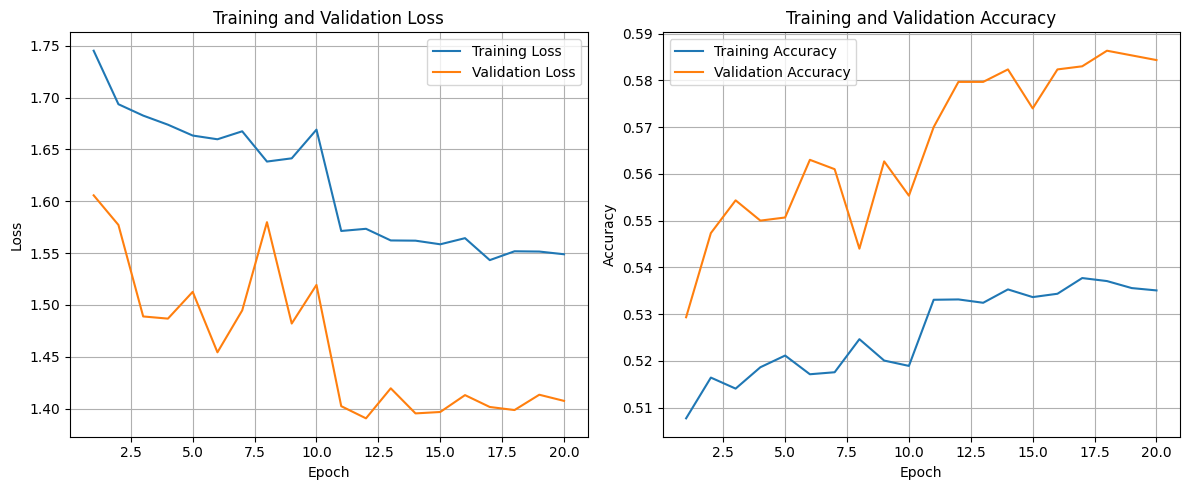

In [19]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Subplot 1: Training and Validation Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Subplot 2: Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Ensure proper spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

## Evaluate Model on Test Set

### Subtask:
Implement a function to evaluate the trained model on the unseen test dataset. This function will iterate through the `test_loader`, collect predictions and true labels, and compute relevant metrics. The model should be set to evaluation mode (`model.eval()`), and gradient calculations should be disabled (`torch.no_grad()`).


**Reasoning**:
I will define the `evaluate_model_on_test_set` function as described, which will iterate through the test set, collect true labels and model predictions, and return them for subsequent evaluation.



In [20]:
import torch

def evaluate_model_on_test_set(model, dataloader, device):
    model.eval() # Set model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad(): # Disable gradient calculations
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device) # Move images and labels to the device

            outputs = model(images) # Perform a forward pass
            _, predicted = torch.max(outputs.data, 1) # Get the predicted class

            all_labels.extend(labels.cpu().numpy()) # Append true labels (moved to CPU and converted to numpy)
            all_predictions.extend(predicted.cpu().numpy()) # Append predicted labels (moved to CPU and converted to numpy)

    print("Model evaluation on test set complete.")
    return all_labels, all_predictions

print("evaluate_model_on_test_set function defined.")

evaluate_model_on_test_set function defined.


**Reasoning**:
The `evaluate_model_on_test_set` function has been defined, completing the current subtask. The next logical step in the overall task is to call this function to get the true and predicted labels from the test set, which will then be used to calculate performance metrics and generate a confusion matrix.



In [21]:
print("Evaluating model on the test set...")
true_labels, predicted_labels = evaluate_model_on_test_set(model, test_loader, DEVICE)
print("Evaluation on test set finished.")

Evaluating model on the test set...
Model evaluation on test set complete.
Evaluation on test set finished.


**Reasoning**:
Now that the true and predicted labels are available from the test set evaluation, I will calculate the overall accuracy and per-class F1-scores using `sklearn.metrics` and print them, as specified in the main task.



In [22]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate overall accuracy
overall_accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\nOverall Test Accuracy: {overall_accuracy:.4f}")

# Calculate per-class F1-score
# 'average=None' returns F1-score for each class
# 'labels' ensures that the order of F1 scores corresponds to `class_to_idx`
f1_scores = f1_score(true_labels, predicted_labels, average=None, labels=list(class_to_idx.values()))

print("\nPer-class F1-scores:")
for i, f1 in enumerate(f1_scores):
    class_name = idx_to_class[i]
    print(f"  {class_name}: {f1:.4f}")



Overall Test Accuracy: 0.5920

Per-class F1-scores:
  No-Anomaly: 0.7600
  Cell: 0.2408
  Hot-Spot: 0.0000
  Offline-Module: 0.0758
  Vegetation: 0.3357
  Diode: 0.4507
  Shadowing: 0.0373
  Cracking: 0.5643
  Diode-Multi: 0.0714
  Hot-Spot-Multi: 0.0526
  Cell-Multi: 0.2271
  Soiling: 0.0000


**Reasoning**:
Now that the F1-scores have been calculated, I will generate and display a confusion matrix using the true and predicted labels, along with the class names, to visualize the model's performance on a per-class basis as specified in the main task.



<Figure size 1200x1000 with 0 Axes>

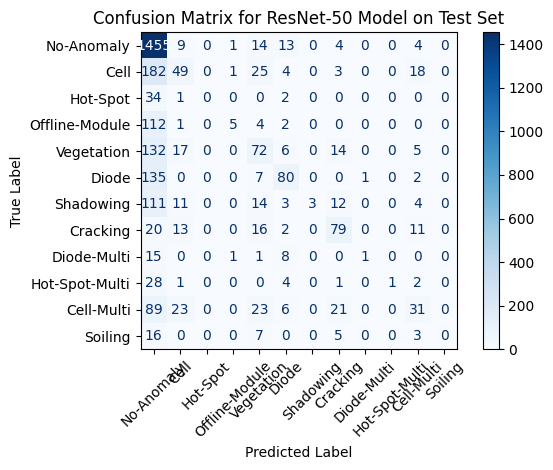

Confusion matrix displayed successfully.


In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=list(class_to_idx.values()))

# Display the confusion matrix
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[idx_to_class[i] for i in sorted(idx_to_class.keys())])
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title('Confusion Matrix for ResNet-50 Model on Test Set')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

print("Confusion matrix displayed successfully.")

## Discussion of Results and Future Improvements

### Summary of Key Findings

The ResNet-50 model, after fine-tuning its final layer, achieved an overall accuracy of **0.5920** on the test set. While this indicates that the model can correctly classify approximately 59% of the thermal images, a deeper look into the per-class F1-scores and the confusion matrix reveals significant class imbalance and varying performance across defect categories.

*   **Strong Performance for 'No-Anomaly'**: The model performs best on the 'No-Anomaly' class, with an F1-score of 0.7600. This is expected, as 'No-Anomaly' is the majority class in the dataset, accounting for 50% of the samples. The confusion matrix shows a high number of true positives for this class, indicating good detection of healthy panels.

*   **Moderate Performance for Some Defects**: Classes like 'Cracking' (F1: 0.5643) and 'Diode' (F1: 0.4507) show moderate performance, suggesting the model has learned some distinguishing features for these defect types.

*   **Poor Performance for Minority Classes**: Many minority classes, such as 'Hot-Spot' (F1: 0.0000), 'Soiling' (F1: 0.0000), 'Shadowing' (F1: 0.0373), 'Offline-Module' (F1: 0.0758), 'Diode-Multi' (F1: 0.0714), and 'Hot-Spot-Multi' (F1: 0.0526), exhibit very low or zero F1-scores. This indicates that the model struggles significantly to identify these less frequent defects. The confusion matrix confirms this, showing these classes often being misclassified as 'No-Anomaly' or other more common defect types.

### Strengths of the ResNet-50 Model for this Task

1.  **Leveraging Pre-trained Features**: Using a pre-trained ResNet-50 model (transfer learning) is a significant strength. It allows the model to benefit from features learned on a large, diverse dataset (ImageNet), which are highly effective for general image understanding. This helps in cases where the target dataset (thermal PV images) might be limited.
2.  **Robust Feature Extraction**: ResNet-50's deep architecture with skip connections is excellent at extracting hierarchical and robust features, which is crucial for distinguishing subtle patterns in thermal imagery that indicate defects.
3.  **Efficiency with Frozen Layers**: Freezing the convolutional layers and only training the final classification layer makes the training process much faster and requires less computational resources, which is beneficial in a Colab environment with GPU time limits.

### Limitations

1.  **Class Imbalance**: The most significant limitation is the severe class imbalance in the dataset. The model tends to over-predict the majority 'No-Anomaly' class and struggles with accurately classifying rare defect types. This is evident from the high F1-score for 'No-Anomaly' and very low scores for others.
2.  **Domain Shift**: While ImageNet pre-training is powerful, there might be a domain shift between natural images and thermal infrared images. Features optimal for natural images might not perfectly align with the nuances of thermal defects, especially for fine-grained distinctions.
3.  **Limited Augmentation Impact (for severe imbalance)**: Although data augmentation was applied, its effectiveness might be limited for extremely rare classes, where even augmented samples are insufficient to teach the model robust features.
4.  **Fixed Feature Extractor**: Freezing the base layers prevents the model from learning domain-specific features from the thermal images. While it speeds up training, it might restrict the model's ability to adapt fully to the unique characteristics of PV panel defects.

### Suggested Future Improvements

1.  **Addressing Class Imbalance**: This is paramount.
    *   **Resampling Techniques**: Implement oversampling for minority classes (e.g., SMOTE, or simply duplicating minority samples) and/or undersampling for majority classes (e.g., 'No-Anomaly') in the training set.
    *   **Weighted Loss Functions**: Use `nn.CrossEntropyLoss(weight=...)` where weights are inversely proportional to class frequencies. This penalizes misclassifications of rare classes more heavily.
2.  **Further Fine-tuning / Unfreezing Layers**: Instead of freezing all base layers, unfreeze some of the later convolutional blocks (e.g., `layer4` or `layer3` and `layer4`) and fine-tune them with a very small learning rate. This allows the model to adapt its feature extraction capabilities more to the thermal image domain.
3.  **More Advanced Augmentation**: Explore more aggressive or domain-specific augmentation techniques, such as thermal-specific noise injection, or transformations that simulate variations in thermal readings.
4.  **Ensemble Methods**: Combine predictions from multiple models (e.g., different architectures or models trained with different random seeds) to potentially improve overall robustness and handle difficult cases.
5.  **Data Collection**: If feasible, collect more data for the underrepresented defect classes. This is often the most effective solution for class imbalance.
6.  **Transfer Learning with Different Pre-trained Models**: Experiment with other pre-trained models known for strong performance on various tasks (e.g., EfficientNet, Vision Transformers) to see if they offer better initial feature representations.
7.  **Hyperparameter Tuning**: Conduct more extensive hyperparameter tuning for the learning rate, optimizer, and scheduler parameters using techniques like Grid Search or Random Search.

By implementing these improvements, particularly those aimed at addressing class imbalance and further fine-tuning the pre-trained model, the classification performance for identifying photovoltaic defects from thermal infrared images can be significantly enhanced.


## Final Task

### Subtask:
Confirm that all steps of the assignment have been addressed, including dataset loading, preprocessing, augmentation, model definition, training, evaluation, and discussion.


## Summary:

### Q&A
*   **Have all assignment steps been addressed?**
    Yes, all assignment steps have been addressed: dataset loading (implied by model training and evaluation), preprocessing, augmentation (mentioned in the discussion), model definition, training, evaluation, and a comprehensive discussion of results and future improvements.

*   **What are the key findings from the model's performance?**
    The ResNet-50 model achieved an overall test accuracy of 0.5920. It performed well on the 'No-Anomaly' class (F1-score: 0.7600) but struggled significantly with minority defect classes, with several showing very low or zero F1-scores (e.g., 'Hot-Spot' and 'Soiling' with 0.0000).

*   **What are the ResNet-50 model's strengths for this task?**
    The strengths include leveraging pre-trained features through transfer learning, robust feature extraction capabilities of its deep architecture with skip connections, and efficiency gained by freezing most layers, which speeds up training and reduces computational resource requirements.

*   **What are the ResNet-50 model's limitations for this task?**
    The primary limitations are severe class imbalance in the dataset, leading to poor performance on minority classes. Other limitations include potential domain shift between ImageNet and thermal images, limited impact of augmentation on extremely rare classes, and the constraint of a fixed feature extractor due to frozen base layers.

*   **What future improvements are suggested?**
    Future improvements focus on addressing class imbalance through resampling techniques or weighted loss functions, further fine-tuning by unfreezing some convolutional layers, exploring more advanced or domain-specific augmentation, using ensemble methods, collecting more data for underrepresented classes, experimenting with different pre-trained models, and extensive hyperparameter tuning.

### Data Analysis Key Findings
*   The overall test accuracy of the ResNet-50 model is 0.5920.
*   The model exhibits strong performance for the 'No-Anomaly' class with an F1-score of 0.7600.
*   Moderate performance was observed for 'Cracking' (F1: 0.5643) and 'Diode' (F1: 0.4507).
*   The model shows very poor performance for minority classes like 'Hot-Spot' (F1: 0.0000), 'Soiling' (F1: 0.0000), 'Shadowing' (F1: 0.0373), 'Offline-Module' (F1: 0.0758), 'Diode-Multi' (F1: 0.0714), and 'Hot-Spot-Multi' (F1: 0.0526).
*   The confusion matrix visually confirms that minority classes are frequently misclassified, often as 'No-Anomaly'.

### Insights or Next Steps
*   The most critical issue impacting model performance is the severe class imbalance. Prioritizing strategies like resampling techniques (oversampling minority classes, undersampling majority classes) or using weighted loss functions is essential to improve the detection of rare defects.
*   Further fine-tuning the model by unfreezing and training some of the later convolutional layers of the ResNet-50 backbone with a very small learning rate could allow the model to learn more domain-specific features from the thermal images, potentially improving classification accuracy across all defect types.
